In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, jarque_bera, kstest, anderson, f_oneway, levene, bartlett, kruskal, ttest_ind
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from pandas.tseries.offsets import Week
from statsmodels.tsa.stattools import adfuller



## Przygotowanie danych

In [ ]:
url = "https://drive.google.com/uc?id=1pRCFwb3-6KCIRrHDnibVuhHt_6cI4p-z"
data = pd.read_csv(url)

In [ ]:
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values('Data').reset_index(drop=True)
data = data.set_index("Data").sort_index()

In [ ]:
all_days = pd.date_range(data.index.min(), data.index.max(), freq="B")
data = data.reindex(all_days)
data["Zamkniecie"] = data["Zamkniecie"].ffill()
data['DzienTygodnia'] = data.index.dayofweek
data['NazwaDnia'] = data.index.day_name()

In [ ]:
def oblicz_stopy_zwrotu(data, dzien_tygodnia):
    data_dzien = data[data['DzienTygodnia'] == dzien_tygodnia].copy()

    if len(data_dzien) < 2:
        return pd.DataFrame()

    # Oblicz stopy zwrotu tydzień do tygodnia
    data_dzien['Zwykla_Stopa'] = data_dzien['Zamkniecie'].pct_change()
    data_dzien['Log_Stopa'] = np.log(data_dzien['Zamkniecie'] / data_dzien['Zamkniecie'].shift(1))

    return data_dzien.reset_index()

# Oblicz stopy zwrotu dla każdego dnia tygodnia
dni_tygodnia = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday'
}

wyniki = {}

for dzien_num, dzien_nazwa in dni_tygodnia.items():
    data_wynik = oblicz_stopy_zwrotu(data, dzien_num)
    wyniki[dzien_nazwa] = data_wynik

## Model ARMA - Poniedziałek

### 1. Dobór najlepszych parametrów

In [ ]:
# Dane dla poniedziałku
data_mon = wyniki['Monday']['Log_Stopa'].dropna().reset_index(drop=True)
train_mon, test_mon = data_mon[:len(data_mon)-10], data_mon[len(data_mon)-10:]

In [ ]:
result_adf = adfuller(train_mon)
print(f"Statystyka ADF: {result_adf[0]:.4f}")
print(f"p-value: {result_adf[1]}")

Statystyka ADF: -14.7445
p-value: 2.540718595386722e-27


In [ ]:
# Wybór najlepszego modelu ARMA
res_mon = arma_order_select_ic(train_mon, max_ar=5, max_ma=5, ic='aic')
p_mon, q_mon = res_mon.aic_min_order
print(f"Najlepszy model ARMA dla poniedziałku: AR={p_mon}, MA={q_mon}")

# Dopasowanie modelu
model_mon = ARIMA(train_mon, order=(p_mon, 0, q_mon)).fit()
print(model_mon.summary())

Najlepszy model ARMA dla poniedziałku: AR=2, MA=3
                               SARIMAX Results                                
Dep. Variable:              Log_Stopa   No. Observations:                  519
Model:                 ARIMA(2, 0, 3)   Log Likelihood                1202.437
Date:                Wed, 15 Oct 2025   AIC                          -2390.874
Time:                        17:43:15   BIC                          -2361.110
Sample:                             0   HQIC                         -2379.213
                                - 519                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.444      0.015       0.000       0.004
ar.L1         -0.0749      0.172     -0.436      0.663      -0.412       0.262
ar

### 2. Diagnostyka modelu

#### 1. Testy normalności reszt

In [ ]:
residuals = model_mon.resid
# Shapiro-Wilk
stat_sw, p_sw = shapiro(residuals)
print(f"Shapiro-Wilk test: statystyka={stat_sw:.4f}, p-value={p_sw}")

# Jarque-Bera
stat_jb, p_jb = jarque_bera(residuals)
print(f"Jarque-Bera test: statystyka={stat_jb:.4f}, p-value={p_jb}")

Shapiro-Wilk test: statystyka=0.8976, p-value=3.90129130738356e-18
Jarque-Bera test: statystyka=1202.8012, p-value=6.531940684192578e-262


#### 2. Test autokorelacji reszt (Ljung-Box)

In [ ]:
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
1   0.006768   0.934436
2   0.044456   0.978017
3   0.046492   0.997371
4   0.122631   0.998195
5   0.194719   0.999170
6   0.269938   0.999630
7   0.458867   0.999584
8   1.596824   0.990981
9   1.732028   0.995032
10  1.732029   0.998012


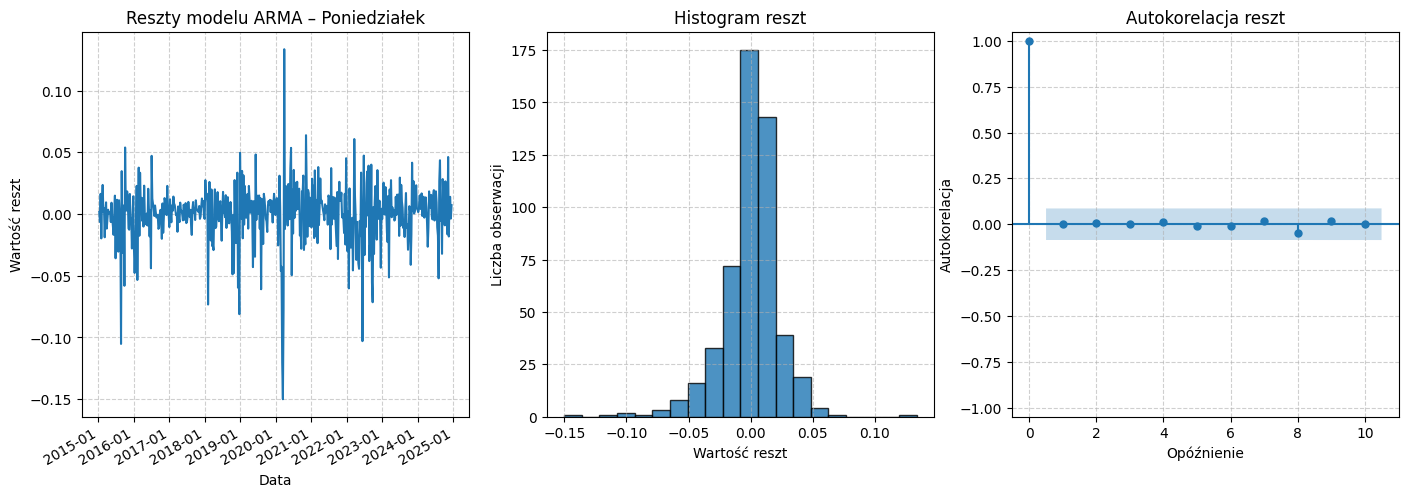

In [ ]:
daty = wyniki['Monday'].loc[wyniki['Monday']['Log_Stopa'].notna(), 'index'][:len(train_mon)]

fig, axs = plt.subplots(1, 3, figsize=(17, 5))
axs[0].plot(daty, residuals, color='tab:blue')
axs[0].set_title('Reszty modelu ARMA – Poniedziałek')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Wartość reszt')
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=15))
plt.setp(axs[0].get_xticklabels(), rotation=30, ha='right')

axs[1].hist(residuals, bins=20, color='tab:blue', edgecolor='black', alpha=0.8)
axs[1].set_title('Histogram reszt')
axs[1].set_xlabel('Wartość reszt')
axs[1].set_ylabel('Liczba obserwacji')
axs[1].grid(True, linestyle='--', alpha=0.6)

plot_acf(residuals, ax=axs[2], lags=10)
axs[2].set_title('Autokorelacja reszt')
axs[2].set_xlabel('Opóźnienie')
axs[2].set_ylabel('Autokorelacja')
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].set_ylim(-1.05, 1.05)

plt.show()

#### 3. Test ARCH (heteroskedastyczność)

In [ ]:
arch_test = het_arch(residuals, nlags=5)
print(f"ARCH test: statystyka={arch_test[0]:.4f}, p-value={arch_test[1]}")

ARCH test: statystyka=120.4629, p-value=2.504334067108396e-24


### Prognoza

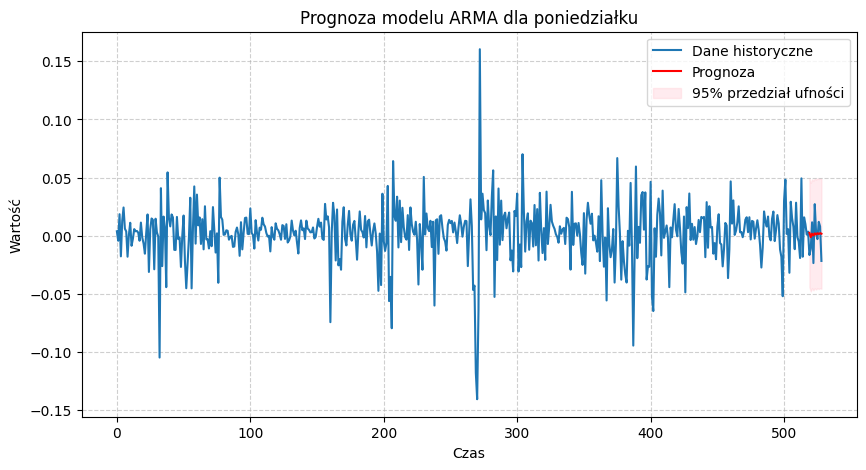

In [ ]:
forecast_res = model_mon.get_forecast(steps=10)
pred_mean = forecast_res.predicted_mean
pred_ci = forecast_res.conf_int(alpha=0.05)
pred_std = forecast_res.se_mean

plt.figure(figsize=(10,5))
plt.plot(data_mon, label='Dane historyczne')
plt.plot(range(len(train_mon), len(train_mon)+10), pred_mean, label='Prognoza', color='red')
plt.fill_between(range(len(train_mon), len(train_mon)+10),
                 pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3,
                 label='95% przedział ufności')

plt.legend()
plt.title('Prognoza modelu ARMA dla poniedziałku')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# Dane rzeczywiste (testowe)
dane_testowe = test_mon.reset_index(drop=True)

# Obliczenia błędów i tabelka wyników
bledy = []
print(f"{'Nr':>3} {'Prognoza':>12} {'Rzecz.':>12} {'Błąd':>12} {'SE':>10} {'CI_lower':>12} {'CI_upper':>12} {'W_przedziale'}")
print("-" * 90)

for i in range(10):
    blad = dane_testowe.iloc[i] - pred_mean.iloc[i]
    bledy.append(blad)
    w_przedziale = pred_ci.iloc[i, 0] <= dane_testowe.iloc[i] <= pred_ci.iloc[i, 1]
    znacznik = "✓" if w_przedziale else "✗"

    print(f"{i+1:>3} {pred_mean.iloc[i]:>12.6f} {dane_testowe.iloc[i]:>12.6f} "
          f"{blad:>12.6f} {pred_std.iloc[i]:>10.6f} "
          f"{pred_ci.iloc[i, 0]:>12.6f} {pred_ci.iloc[i, 1]:>12.6f} {znacznik}")

# Szerokość przedziałów ufności
ci_width = pred_ci.iloc[:, 1] - pred_ci.iloc[:, 0]

# Metryki błędów
bledy = np.array(bledy)
mae = np.mean(np.abs(bledy))
rmse = np.sqrt(np.mean(bledy**2))
mape = np.mean(np.abs(bledy / dane_testowe)) * 100

# Procent obserwacji w przedziale ufności
w_przedziale_count = sum([pred_ci.iloc[i, 0] <= dane_testowe.iloc[i] <= pred_ci.iloc[i, 1]
                            for i in range(10)])
procent_w_przedziale = (w_przedziale_count / 10) * 100

# Wyniki
print(f"\n{'METRYKI DOKŁADNOŚCI PROGNOZY – Poniedziałek':^95}")
print("-" * 95)
print(f"MAE (Mean Absolute Error):        {mae:.6f}")
print(f"RMSE (Root Mean Squared Error):   {rmse:.6f}")
print(f"MAPE (Mean Absolute % Error):     {mape:.2f}%")
print(f"Średnia szerokość przedziału CI:  {ci_width.mean():.6f}")
print(f"Obserwacje w przedziale ufności:  {w_przedziale_count}/10 ({procent_w_przedziale:.0f}%)")


 Nr     Prognoza       Rzecz.         Błąd         SE     CI_lower     CI_upper W_przedziale
------------------------------------------------------------------------------------------
  1     0.002429    -0.016602    -0.019031   0.023853    -0.044322     0.049180 ✓
  2    -0.001238    -0.011301    -0.010063   0.023855    -0.047992     0.045517 ✓
  3     0.001692     0.011520     0.009828   0.023873    -0.045099     0.048482 ✓
  4     0.000158    -0.023564    -0.023722   0.024052    -0.046983     0.047299 ✓
  5     0.002005     0.027119     0.025114   0.024054    -0.045141     0.049151 ✓
  6     0.000960     0.002601     0.001642   0.024115    -0.046305     0.048224 ✓
  7     0.002130    -0.002950    -0.005080   0.024115    -0.045134     0.049395 ✓
  8     0.001424     0.011918     0.010493   0.024136    -0.045881     0.048730 ✓
  9     0.002170     0.007912     0.005742   0.024136    -0.045136     0.049475 ✓
 10     0.001696    -0.021720    -0.023417   0.024143    -0.045623     0.04901

## Model ARMA - Środa

### 1. Dobór najlepszych parametrów

In [ ]:
# Dane dla środy
data_wed = wyniki['Wednesday']['Log_Stopa'].dropna().reset_index(drop=True)
train_wed, test_wed = data_wed[:len(data_wed)-10], data_wed[len(data_wed)-10:]

In [ ]:
result_adf = adfuller(train_wed)
print(f"Statystyka ADF: {result_adf[0]:.4f}")
print(f"p-value: {result_adf[1]}")

Statystyka ADF: -22.3986
p-value: 0.0


In [ ]:
# Wybór najlepszego modelu ARMA
res_wed = arma_order_select_ic(train_wed, max_ar=5, max_ma=5, ic='aic')
p_wed, q_wed = res_wed.aic_min_order
print(f"Najlepszy model ARMA dla środy: AR={p_wed}, MA={q_wed}")

# Dopasowanie modelu
model_wed = ARIMA(train_wed, order=(p_wed, 0, q_wed)).fit()
print(model_wed.summary())

Najlepszy model ARMA dla środy: AR=0, MA=0
                               SARIMAX Results                                
Dep. Variable:              Log_Stopa   No. Observations:                  519
Model:                          ARIMA   Log Likelihood                1236.385
Date:                Wed, 15 Oct 2025   AIC                          -2468.769
Time:                        17:44:04   BIC                          -2460.265
Sample:                             0   HQIC                         -2465.438
                                - 519                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.860      0.063      -0.000       0.004
sigma2         0.0005   1.66e-05     29.980      0.000       0.000       0.001
Ljung-Box

### 2. Diagnostyka modelu

#### 1. Testy normalności reszt

In [ ]:
residuals = model_wed.resid
# Shapiro-Wilk
stat_sw, p_sw = shapiro(residuals)
print(f"Shapiro-Wilk test: statystyka={stat_sw:.4f}, p-value={p_sw}")

# Jarque-Bera
stat_jb, p_jb = jarque_bera(residuals)
print(f"Jarque-Bera test: statystyka={stat_jb:.4f}, p-value={p_jb}")

Shapiro-Wilk test: statystyka=0.9009, p-value=7.712562464667375e-18
Jarque-Bera test: statystyka=1127.4384, p-value=1.5130927225876096e-245


#### 2. Test autokorelacji reszt (Ljung-Box)

In [ ]:
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(lb_test)

     lb_stat  lb_pvalue
1   0.068233   0.793927
2   0.095206   0.953512
3   0.279863   0.963770
4   2.923582   0.570694
5   3.427204   0.634430
6   6.455143   0.374179
7   6.485410   0.484345
8   6.502001   0.591186
9   8.137170   0.520384
10  8.674078   0.563289


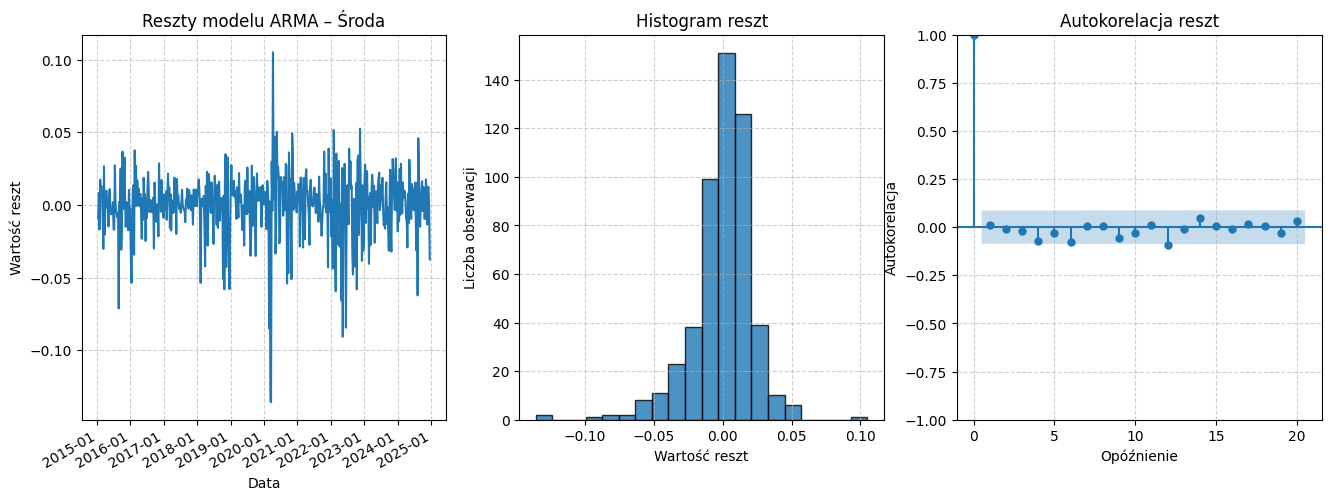

In [ ]:
daty = wyniki['Wednesday'].loc[wyniki['Wednesday']['Log_Stopa'].notna(), 'index'][:len(train_wed)]

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].plot(daty, residuals, color='tab:blue')
axs[0].set_title('Reszty modelu ARMA – Środa')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Wartość reszt')
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=15))
plt.setp(axs[0].get_xticklabels(), rotation=30, ha='right')

axs[1].hist(residuals, bins=20, color='tab:blue', edgecolor='black', alpha=0.8)

axs[1].set_title('Histogram reszt')
axs[1].set_xlabel('Wartość reszt')
axs[1].set_ylabel('Liczba obserwacji')
axs[1].grid(True, linestyle='--', alpha=0.6)

plot_acf(residuals, ax=axs[2], lags=20)
axs[2].set_title('Autokorelacja reszt')
axs[2].set_xlabel('Opóźnienie')
axs[2].set_ylabel('Autokorelacja')
axs[2].grid(True, linestyle='--', alpha=0.6)

plt.show()

#### 3. Test ARCH (heteroskedastyczność)

In [ ]:
arch_test = het_arch(residuals, nlags=5)
print(f"ARCH test: statystyka={arch_test[0]:.4f}, p-value={arch_test[1]}")

ARCH test: statystyka=81.5232, p-value=4.0279189120158927e-16


### Prognoza

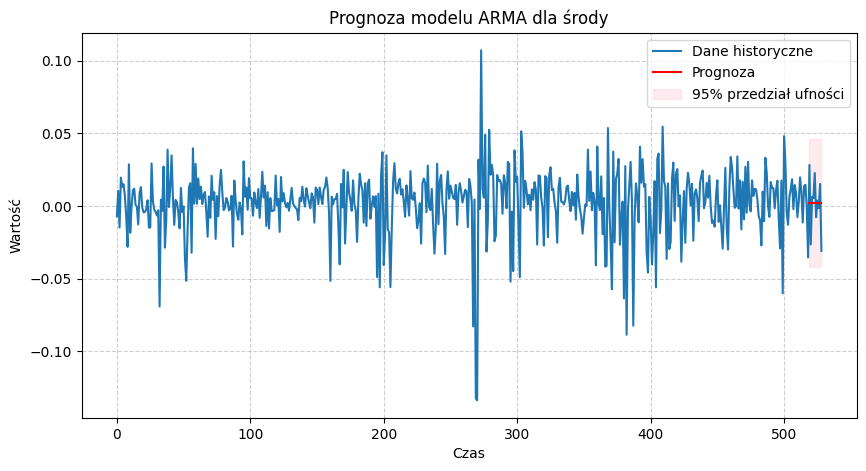

In [ ]:
forecast_res = model_wed.get_forecast(steps=10)
pred_mean = forecast_res.predicted_mean
pred_ci = forecast_res.conf_int(alpha=0.05)
pred_std = forecast_res.se_mean

plt.figure(figsize=(10,5))
plt.plot(data_wed, label='Dane historyczne')
plt.plot(range(len(train_wed), len(train_wed)+10), pred_mean, label='Prognoza', color='red')
plt.fill_between(range(len(train_wed), len(train_wed)+10),
                 pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='pink', alpha=0.3,
                 label='95% przedział ufności')
plt.legend()
plt.title('Prognoza modelu ARMA dla środy')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [ ]:
dane_testowe = test_wed.reset_index(drop=True)

bledy = []
print(f"{'Nr':>3} {'Prognoza':>12} {'Rzecz.':>12} {'Błąd':>12} {'SE':>10} {'CI_lower':>12} {'CI_upper':>12} {'W_przedziale'}")
print("-" * 90)

for i in range(10):
    blad = dane_testowe.iloc[i] - pred_mean.iloc[i]
    bledy.append(blad)
    w_przedziale = pred_ci.iloc[i, 0] <= dane_testowe.iloc[i] <= pred_ci.iloc[i, 1]
    znacznik = "✓" if w_przedziale else "✗"

    print(f"{i+1:>3} {pred_mean.iloc[i]:>12.6f} {dane_testowe.iloc[i]:>12.6f} "
          f"{blad:>12.6f} {pred_std.iloc[i]:>10.6f} "
          f"{pred_ci.iloc[i, 0]:>12.6f} {pred_ci.iloc[i, 1]:>12.6f} {znacznik}")

# Szerokość przedziałów ufności
ci_width = pred_ci.iloc[:, 1] - pred_ci.iloc[:, 0]

# Metryki błędów
bledy = np.array(bledy)
mae = np.mean(np.abs(bledy))
rmse = np.sqrt(np.mean(bledy**2))
mape = np.mean(np.abs(bledy / dane_testowe)) * 100

# Procent obserwacji w przedziale ufności
w_przedziale_count = sum([pred_ci.iloc[i, 0] <= dane_testowe.iloc[i] <= pred_ci.iloc[i, 1]
                            for i in range(10)])
procent_w_przedziale = (w_przedziale_count / 10) * 100

# Wyniki
print(f"\n{'METRYKI DOKŁADNOŚCI PROGNOZY – Środa':^95}")
print("-" * 95)
print(f"MAE (Mean Absolute Error):        {mae:.6f}")
print(f"RMSE (Root Mean Squared Error):   {rmse:.6f}")
print(f"MAPE (Mean Absolute % Error):     {mape:.2f}%")
print(f"Średnia szerokość przedziału CI:  {ci_width.mean():.6f}")
print(f"Obserwacje w przedziale ufności:  {w_przedziale_count}/10 ({procent_w_przedziale:.0f}%)")


 Nr     Prognoza       Rzecz.         Błąd         SE     CI_lower     CI_upper W_przedziale
------------------------------------------------------------------------------------------
  1     0.002046     0.028188     0.026143   0.022340    -0.041739     0.045830 ✓
  2     0.002046    -0.026577    -0.028622   0.022340    -0.041739     0.045830 ✓
  3     0.002046     0.006207     0.004161   0.022340    -0.041739     0.045830 ✓
  4     0.002046     0.005335     0.003290   0.022340    -0.041739     0.045830 ✓
  5     0.002046     0.022676     0.020630   0.022340    -0.041739     0.045830 ✓
  6     0.002046    -0.007762    -0.009808   0.022340    -0.041739     0.045830 ✓
  7     0.002046     0.003664     0.001619   0.022340    -0.041739     0.045830 ✓
  8     0.002046    -0.001570    -0.003616   0.022340    -0.041739     0.045830 ✓
  9     0.002046     0.015117     0.013071   0.022340    -0.041739     0.045830 ✓
 10     0.002046    -0.031091    -0.033137   0.022340    -0.041739     0.04583